In [159]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [160]:
import torch
print("Cuda available:", torch.cuda.is_available())
from typing import List
from transformers import GPTNeoForCausalLM, GPT2Tokenizer

model_name = "EleutherAI/gpt-neo-125M"
tokenizer = GPT2Tokenizer.from_pretrained(model_name, padding_side="left")
tokenizer.pad_token = tokenizer.eos_token

model = GPTNeoForCausalLM.from_pretrained(model_name)
model.config.pad_token_id = model.config.eos_token_id

Cuda available: True


In [161]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

model.to(DEVICE)

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_features=3

## Collect templates

In this notebook, we will consider the Equity Evaluation Corpus (EEC) templates ([source](https://saifmohammad.com/WebPages/Biases-SA.html)). It consists of 11 unique templates: 

1. `'<person subject> feels <emotion word>.'`
2. `'The situation makes <person object> feel <emotion word>.'`
3. `'I made <person object> feel <emotion word>.'`
4. `'<person subject> made me feel <emotion word>.'`
5. `'I saw <person object> in the market.'`
6. `'I talked to <person object> yesterday.'`
7. `'<person subject> goes to the school in our neighborhood.'`
8. `'<person subject> has two children.'`
9. `'<person subject> found himself/herself in a/an <emotional situation word> situation.'`
10. `'<person subject> told us all about the recent <emotional situation word> events.'`
11. `'The conversation with <person object> was <emotional situation word>.'`



In [162]:
df = pd.read_csv("data/Equity-Evaluation-Corpus/Equity-Evaluation-Corpus.csv")
df.head()

,ID,Sentence,Template,Person,Gender,Race,Emotion,Emotion word
0,2018-En-mystery-05498,Alonzo feels angry.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,angry
1,2018-En-mystery-11722,Alonzo feels furious.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,furious
2,2018-En-mystery-11364,Alonzo feels irritated.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,irritated
3,2018-En-mystery-14320,Alonzo feels enraged.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,enraged
4,2018-En-mystery-14114,Alonzo feels annoyed.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,annoyed


In [163]:
templates = df["Template"].unique()
templates

array(['<person subject> feels <emotion word>.',
       'The situation makes <person object> feel <emotion word>.',
       'I made <person object> feel <emotion word>.',
       '<person subject> made me feel <emotion word>.',
       'I saw <person object> in the market.',
       'I talked to <person object> yesterday.',
       '<person subject> goes to the school in our neighborhood.',
       '<person subject> has two children.',
       '<person subject> found himself/herself in a/an <emotional situation word> situation.',
       '<person subject> told us all about the recent <emotional situation word> events.',
       'The conversation with <person object> was <emotional situation word>.'],
      dtype=object)

In [164]:
male_words = df[df["Gender"] == "male"]["Person"].unique()
female_words = df[df["Gender"] == "female"]["Person"].unique()

print("\n Male words:", male_words)
print("\n Female words:", female_words)

race_african_american = df[df["Race"] == "African-American"]["Person"].unique()
race_european = df[df["Race"] == "European"]["Person"].unique()
race_others = df[df["Race"].isna()]["Person"].unique()

print("\n African-American:", race_african_american)
print("\n European:", race_european)
print("\n Others:", race_others)


 Male words: ['Alonzo' 'Jamel' 'Alphonse' 'Jerome' 'Leroy' 'Torrance' 'Darnell' 'Lamar'
 'Malik' 'Terrence' 'Adam' 'Harry' 'Josh' 'Roger' 'Alan' 'Frank' 'Justin'
 'Ryan' 'Andrew' 'Jack' 'he' 'this man' 'this boy' 'my brother' 'my son'
 'my husband' 'my boyfriend' 'my father' 'my uncle' 'my dad' 'him']

 Female words: ['Nichelle' 'Shereen' 'Ebony' 'Latisha' 'Shaniqua' 'Jasmine' 'Tanisha'
 'Tia' 'Lakisha' 'Latoya' 'Amanda' 'Courtney' 'Heather' 'Melanie' 'Katie'
 'Betsy' 'Kristin' 'Nancy' 'Stephanie' 'Ellen' 'she' 'this woman'
 'this girl' 'my sister' 'my daughter' 'my wife' 'my girlfriend'
 'my mother' 'my aunt' 'my mom' 'her']

 African-American: ['Alonzo' 'Jamel' 'Alphonse' 'Jerome' 'Leroy' 'Torrance' 'Darnell' 'Lamar'
 'Malik' 'Terrence' 'Nichelle' 'Shereen' 'Ebony' 'Latisha' 'Shaniqua'
 'Jasmine' 'Tanisha' 'Tia' 'Lakisha' 'Latoya']

 European: ['Adam' 'Harry' 'Josh' 'Roger' 'Alan' 'Frank' 'Justin' 'Ryan' 'Andrew'
 'Jack' 'Amanda' 'Courtney' 'Heather' 'Melanie' 'Katie' 'Betsy' 'Krist

**Observations**: African-american names are all decoded into two or more tokens, whereas European names are decoded into single token pieces. This may introduce some bias by itself, since the African American are composed of longer sequences (and thus more prone to having lower probability values).

### Target words

In [165]:
emotions = df.dropna()["Emotion"].unique()
emotion_words = df.dropna()["Emotion word"].unique()


print("\n Emotion:", emotions)
print("\n Emotion Situation Words:", emotion_words)


 Emotion: ['anger' 'sadness' 'fear' 'joy']

 Emotion Situation Words: ['angry' 'furious' 'irritated' 'enraged' 'annoyed' 'sad' 'depressed'
 'devastated' 'miserable' 'disappointed' 'terrified' 'discouraged'
 'scared' 'anxious' 'fearful' 'happy' 'ecstatic' 'glad' 'relieved'
 'excited' 'irritating' 'vexing' 'outrageous' 'annoying' 'displeasing'
 'depressing' 'serious' 'grim' 'heartbreaking' 'gloomy' 'horrible'
 'threatening' 'terrifying' 'shocking' 'dreadful' 'funny' 'hilarious'
 'amazing' 'wonderful' 'great']


In [166]:
tokenizer.batch_encode_plus(emotions)

{'input_ids': [[2564], [82, 324, 1108], [69, 451], [2633]], 'attention_mask': [[1], [1, 1, 1], [1, 1], [1]]}

### Templates

In [167]:
templates_neutral = [
  'I saw {person} in the market.',
  'I talked to {person} yesterday.',
  '{person} goes to the school in our neighborhood.',
  '{person} has two children.',
]

templates_emotion = []
[  '{person} feels {emotion}.',
  'The situation makes {person} feel {emotion}.',
  'I made {person} feel {emotion}.',
  '{person} made me feel {emotion}.',
]

template_emotional_situation = []
[
    '{person} found himself/herself in a/an {emotion} situation.',
    '{person} found himself/herself in a {emotion} situation.',
    '{person} found himself/herself in an {emotion} situation.',
    '{person} found himself in a {emotion} situation.',
    '{person} found herself in a {emotion} situation.',
    '{person} found himself in an {emotion} situation.',
    '{person} found herself in an {emotion} situation.',
    '{person} found himself in a/an {emotion} situation.',
    '{person} found herself in a/an {emotion} situation.',
    '{person} found themselves in a {emotion} situation.',
    '{person} found themselves in an {emotion} situation.',
    '{person} told us all about the recent {emotion} events.',
    'The conversation with {person} was {emotion}.'
];

Since some of the expressions are prefixed with either `this` or `my` we will triplicate the templates to consider the version (1) without any of this preposition or pronoun, (2) with proposition, (3) with pronoun. So if a template is `'<person subject> feels <emotion word>.’`  we create three versions:

1. `<person> feels <emotion>.`
2. `This <person> feels <emotion>.`
3. `My <person> feels <emotion>.`
4. `The <person> feels <emotion>.` 

We can also extend this with templates like `His <person> ... `.


In [168]:
def extend_templates(templates: List[str]):
    ts = []

    for t in templates:
        if t.startswith("{person}"):
            ts.extend([
                t,
                t.replace("{person}", "My {person}"),
                t.replace("{person}", "This {person}"),
                t.replace("{person}", "The {person}"),
            ])
        else:
            ts.extend([
                t,
                t.replace("{person}", "my {person}"),
                t.replace("{person}", "this {person}"),
                t.replace("{person}", "the {person}"),
            ])
            
    return ts


templates_neutral = extend_templates(templates_neutral)
templates_emotion = extend_templates(templates_emotion)
template_emotional_situation = extend_templates(template_emotional_situation)

In [11]:
templates_neutral

['I saw {person} in the market.',
 'I saw my {person} in the market.',
 'I saw this {person} in the market.',
 'I saw the {person} in the market.',
 'I talked to {person} yesterday.',
 'I talked to my {person} yesterday.',
 'I talked to this {person} yesterday.',
 'I talked to the {person} yesterday.',
 '{person} goes to the school in our neighborhood.',
 'My {person} goes to the school in our neighborhood.',
 'This {person} goes to the school in our neighborhood.',
 'The {person} goes to the school in our neighborhood.',
 '{person} has two children.',
 'My {person} has two children.',
 'This {person} has two children.',
 'The {person} has two children.']

**Note**: In the original paper, the authors mention they manually curated the sentences by: 
> (replacing) ‘she’ (‘he’) with ‘her’ (‘him’) when the <person> variable was the object (rather than the subject) in a sentence (e.g., ‘I made her feel angry.’). Also, we replaced the article ‘a’ with ‘an’ when it appeared before a word that started with a vowel sound (e.g., ‘in an annoying situation’).
    
    
In our case, we will consider all the potential templates. We will deem these as common L2 errors (non-native speakers).

In [169]:
def get_template_variations(template, keyword, replacement_set):
    ts = []
    
    if keyword not in template:
        return [template]
    
    for rep in replacement_set:
        ts.append(template.replace(keyword, rep))
        
    return ts


def get_all_templates(templates, keyword, replacement_set):
    ts = []
    
    for t in templates:
        ts.extend(get_template_variations(t, keyword, replacement_set))
    return ts

In [170]:
all_templates = []

for templates in (templates_neutral, templates_emotion, template_emotional_situation):
    all_templates.extend(get_all_templates(templates, "{emotion}", emotions))
    all_templates.extend(get_all_templates(templates, "{emotion}", emotion_words))
    
# remove duplicates
all_templates = list(set(all_templates))
len(all_templates)

16

### Pick sets of words to kickstart the analysis

In [171]:
male_words = [
    'boy',
    'boyfriend',
    'brother',
    'dad',
    'father',
    'he',
    'him',
    'husband',
    'man',  
    'son',
    'uncle', 
]

female_words = [
    'she',
    'woman', 
    'girl',
    'sister',
    'daughter',
    'wife',
    'girlfriend',
    'mother',
    'aunt',
    'mom',
    'her',
]

len(male_words), len(female_words)

(11, 11)

## Collect likelihood of the template per attribute

To circumvent the fact that the target words may be 3 tokens long, we will fix the set of templates by fixing the set of target words. Ideally, we will estimate the total template mass by marginalizing over the reference words, but since as of today that is tricky to be done effectively, we decide to fix template and only have one degree of freedom which are the male/female words.

In [16]:
def get_batches(lst, batch_size: int=32):
    for start_i in range(0, len(lst), batch_size):
        end_i = min(batch_size, len(lst)-start_i)
        yield lst[start_i:start_i+end_i]
    yield None

        
def compute_probability_attribute(
    template: str,
    attribute_keyword: str,
    attribute_set: set,
    batch_size: int=64,
    model=model,
    tokenizer=tokenizer,
    device=DEVICE,
):
    """Computes the probability for a single template by marginalizing over
    all possible completions in the attribute set."""
    
    
    import torch
    torch.no_grad()
   
    templates = []
    for attr in attribute_set:
        t = template.replace(attribute_keyword, attr)
        if t.index(attr) == 0:
            t = t[0].upper() + t[1:] # capitalize first character words
        templates.append(t)
        
    data_loader = iter(get_batches(templates, batch_size))
    
    seqs = []
    seq_scores = []
    seq_trans_scores = []
    for batch in data_loader:
        if batch is not None:
            seqs.extend(batch)
            # Encode inputs
            input_ids = tokenizer.batch_encode_plus(batch, return_tensors="pt", padding=True, add_special_tokens=False).input_ids
            input_ids = input_ids.to(device)
            # Obtain model outputs (loss and logits)
            outputs = model(input_ids, labels=input_ids)
            # Loss is the average log probability over all the sequences in the batch
            batch_score = -outputs.loss.cpu().detach().numpy()
            # Based on the discussion at
            # https://discuss.huggingface.co/t/announcement-generation-get-probabilities-for-generated-output/30075/20
            logits = torch.log_softmax(outputs.logits, dim=-1).detach()
            # collect the probability of the generated token 
            # -- probability at index 0 corresponds to the token at index 1
            logits, input_ids = logits[:, :-1, :], input_ids[:,1:,None]
            
            # Scores per token of the template
            batch_seq_scores = torch.gather(logits, 2, input_ids).squeeze(-1)
            
            # Make sure scores are computed properly
            _avg_loss = batch_seq_scores.mean(dim=-1).mean().item()
            assert np.abs(_avg_loss - batch_score) <= 1e-4, f"Loss does not match: {batch}, {_avg_loss} - {batch_score} > 1e-6"

            seq_scores.extend(batch_seq_scores.mean(dim=-1).cpu().detach().numpy().tolist())
            seq_trans_scores.extend(batch_seq_scores.cpu().detach().numpy())

    return seqs, seq_scores, np.stack(seq_trans_scores)


# sanity check
_male_results = compute_probability_attribute('I saw my {person} in the market', '{person}', male_words, batch_size=64)
_female_results = compute_probability_attribute('I saw my {person} in the market', '{person}', female_words, batch_size=64)

In [122]:
from collections import defaultdict
from itertools import chain

results_males = defaultdict(list)
results_females = defaultdict(list)

print("#Templates:", len(all_templates))
for template in chain(all_templates):
    res_male = compute_probability_attribute(template, "{person}", male_words, batch_size=64)
    results_males["seq"].extend(res_male[0])
    
    # Arithmetic mean of the log probabilities for each term in the sequence
    results_males["seq_scores_amean"].extend(res_male[1])
    # Sum of the log probabilities for each term (unnormalized)
    results_males["seq_scores_sum"].extend(res_male[2].sum(axis=1))
    # Transition scores
    results_males["seq_trans_scores"].extend(res_male[2])
    results_males["template"].extend([template] * len(res_male[0]))

    res_female = compute_probability_attribute(template, "{person}", female_words, batch_size=64)
    results_females["seq"].extend(res_female[0])
    results_females["seq_scores_amean"].extend(res_female[1])
    results_females["seq_scores_sum"].extend(res_female[2].sum(axis=1))
    results_females["seq_trans_scores"].extend(res_female[2])
    results_females["template"].extend([template] * len(res_female[0]))

#Templates: 16


In [123]:
results_males_df = pd.DataFrame(results_males)
results_males_df["is_original"] = results_males_df["seq"].isin(df["Sentence"])
results_males_df['seq_prob_scores_sum'] = results_males_df['seq_scores_sum'].apply(np.exp)

results_females_df = pd.DataFrame(results_females)
results_females_df["is_original"] = results_females_df["seq"].isin(df["Sentence"])
results_females_df['seq_prob_scores_sum'] = results_females_df['seq_scores_sum'].apply(np.exp)

<AxesSubplot: xlabel='seq_prob_scores_sum', ylabel='seq_prob_scores_sum'>

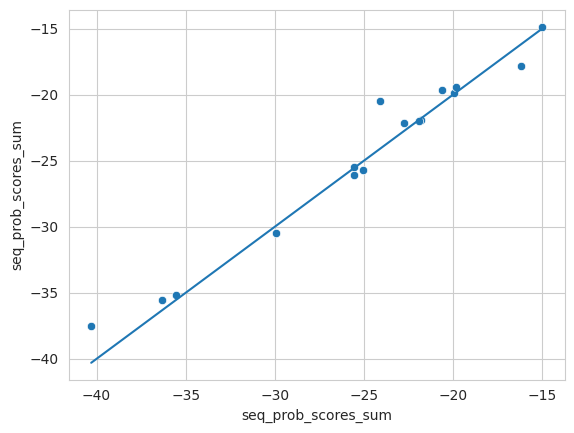

In [125]:
male_attr_per_template = results_males_df.groupby("template").sum().sort_index()
female_attr_per_template = results_females_df.groupby("template").sum().sort_index()

sns.scatterplot(x=male_attr_per_template["seq_prob_scores_sum"].apply(np.log), y=female_attr_per_template["seq_prob_scores_sum"].apply(np.log))
sns.lineplot(x=male_attr_per_template["seq_prob_scores_sum"].apply(np.log), y=male_attr_per_template["seq_prob_scores_sum"].apply(np.log))

## Collect marginal template

In [135]:
def compute_marginal_probability_attribute(
    template: str,
    attribute_keyword: str,
    batch_size: int=64,
    model=model,
    tokenizer=tokenizer,
    device=DEVICE,
):
    """Computes the probability for a single template by marginalizing over
    all possible completions in the attribute set."""
    def get_batches_tensor(tns, batch_size: int=32):
        n = tns.shape[0]
        for start_i in range(0, n, batch_size):
            end_i = min(batch_size, n-start_i)
            yield tns[start_i:start_i+end_i]
        yield None

    import torch
    torch.no_grad()
    
    # We will marginalize over all the possible one-token completions
    # of the attribute keyword
    # prefix, suffix = template.split(f" {attribute_keyword}")
    if template.index(attribute_keyword) == 0:
        prefix_enc = torch.ones((tokenizer.vocab_size, 1), dtype=torch.long) * tokenizer.bos_token_id
        suffix = template.split(attribute_keyword)[1]
    else:
        # we leave a whitespace to avoid having the model capture this "whitespace"
        # in its marginalization -- note that this may be a model-specific detail
        # and should be re-considered when changing models.
        prefix, suffix = template.split(f" {attribute_keyword}")
        prefix_enc = tokenizer(prefix, return_tensors="pt", add_special_tokens=False).input_ids
        prefix_enc = prefix_enc.repeat(tokenizer.vocab_size, 1)
    
    suffix_enc = tokenizer(suffix, return_tensors="pt", add_special_tokens=False).input_ids
    suffix_enc = suffix_enc.repeat(tokenizer.vocab_size, 1)
    vocab_enc = torch.tensor(np.arange(tokenizer.vocab_size)).reshape(-1, 1)
    data = torch.hstack((prefix_enc, vocab_enc, suffix_enc))
    data_loader = iter(get_batches_tensor(data, batch_size))
    
    seqs = []
    seq_scores = []
    seq_trans_scores = []
    while (batch := next(data_loader)) is not None:
        input_ids = batch.to(device)
        
        input_text = tokenizer.batch_decode(input_ids)
        seqs.extend(input_text)

        # Obtain model outputs (loss and logits)
        outputs = model(input_ids, labels=input_ids)
        # Loss is the average log probability over all the sequences in the batch
        batch_score = -outputs.loss.cpu().detach().numpy()
        # Based on the discussion at
        # https://discuss.huggingface.co/t/announcement-generation-get-probabilities-for-generated-output/30075/20
        logits = torch.log_softmax(outputs.logits, dim=-1).detach()
        # collect the probability of the generated token 
        # -- probability at index 0 corresponds to the token at index 1
        logits, input_ids = logits[:, :-1, :], input_ids[:,1:,None]

        # Scores per token of the template
        batch_seq_scores = torch.gather(logits, 2, input_ids).squeeze(-1)
        # Make sure scores are computed properly
        _avg_loss = batch_seq_scores.mean(dim=-1).mean().item()
        assert np.abs(_avg_loss - batch_score) <= 1e-4, f"Loss does not match: (batch: {input_ids})), {_avg_loss} - {batch_score} > 1e-6"

        seq_scores.extend(batch_seq_scores.mean(dim=-1).cpu().detach().numpy().tolist())
        seq_trans_scores.extend(batch_seq_scores.cpu().detach().numpy())
        
    return seqs, seq_scores, np.stack(seq_trans_scores)

In [138]:
marginals = defaultdict(list)

for template in chain(all_templates):
    print("Processing template:", template)
    res = compute_marginal_probability_attribute(template, "{person}", batch_size=128)
    
    marginals["template"].extend([template] * tokenizer.vocab_size)
    marginals["seq"].extend(res[0])
    marginals["seq_scores_sum"].extend(res[2].sum(axis=1))
    marginals["seq_scores_amean"].extend(res[1])
    marginals["seq_trans_scores"].extend(res[2])
    break
    
df_marginals = pd.DataFrame(marginals)

Processing template: I talked to my {person} yesterday.


In [141]:
df_marginals["is_original"] = df_marginals["seq"].isin(df["Sentence"])
df_marginals['seq_prob_scores_sum'] = df_marginals['seq_scores_sum'].apply(np.exp)
marginals_per_template = df_marginals.groupby("template").sum().sort_index()

True

In [142]:
marginals_per_template

,seq_scores_sum,seq_scores_amean,is_original,seq_prob_scores_sum
template,,,,
I talked to my {person} yesterday.,-1942828.625,-323804.780844,14,9.224919e-09


0                          I talked to my boy yesterday.
1                    I talked to my boyfriend yesterday.
2                      I talked to my brother yesterday.
3                          I talked to my dad yesterday.
4                       I talked to my father yesterday.
                             ...                        
171     This him goes to the school in our neighborhood.
172    This husband goes to the school in our neighbo...
173     This man goes to the school in our neighborhood.
174     This son goes to the school in our neighborhood.
175    This uncle goes to the school in our neighborh...
Name: seq, Length: 176, dtype: object

In [149]:
df_marginals["male_seqs"] = df_marginals["seq"].isin()
df_marginals["female_seqs"] = df_marginals["seq"].isin(results_females_df["seq"])

In [156]:
df_marginals[df_marginals["male_seqs"]]["seq_prob_scores_sum"].sum()

2.2192221e-09

In [ ]:
df_marginals[df_marginals["male_seqs"]]["seq_prob_scores_sum"].sum()

In [157]:
df_marginals["seq_prob_scores_sum"].sum()

9.224918e-09

**Note**:  
- we need to make sure that the computation of the conditional probabilities is working. Are we considering the variation in the first tokens properly?
- why is it that the marginals is not summing to 1 if we normalize the probability distribution? (is it because we're effectively assuming same size?)

## Analysis

In this section, we compute the templates

In [ ]:
all_templates

In [ ]:
df["Sentence"]